<a href="https://colab.research.google.com/github/aborundiya/CNN/blob/master/CIFAR_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.optim as optim 
from torchvision import  models 

#checking if the GPU Is availbale

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#Loading and Transforming the images 

In [0]:
transform_train = transforms.Compose([
                                      transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
transform_test = transforms.Compose([
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [5]:
train_set = torchvision.datasets.CIFAR10('./data',train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10('./data',train=False, download=True,transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#Visualization of the dataset using dataloader and custom imshow 

In [6]:
num_classes = 10 
batch_size = 4 
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
images , labels = iter(train_dataloader).next()
print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
2


In [0]:
def imshow(img, title):
  nimg = img.numpy() / 2 + 0.5  # convert the image to numpy and re-normalize 
  plt.figure(figsize = (batch_size,1))
  plt.axis("off")
  plt.imshow(np.transpose(nimg,(1,2,0)))  # converting the image to suit the built in imshow axis x,y,z 
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images, labels = iter(dataloader).next()
  img = torchvision.utils.make_grid(images)
  imshow(img,title=[str(x.item()) for x in labels])
  

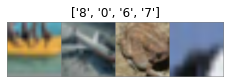

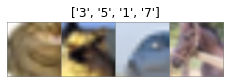

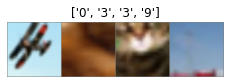

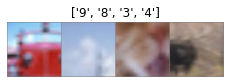

In [9]:

for i in range(4):
  show_batch_images(train_dataloader)

#Transfer Learning from Pre Trained Models 

In [0]:
batch_size = 16 
trainloader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

In [11]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
for param in vgg.parameters():
  param.requires_grad = False 

In [13]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features,num_classes)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [14]:
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
def evaluation(dataloader, model):
  total , correct = 0 , 0 
  for data in dataloader:

    inputs, labels = data 
   
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    
    _ , pred = torch.max(outputs.data,1)
    
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * (correct / total )


#Checkpoints for capturing the state of network with minimum loss 

In [0]:

import copy

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
lr = [0.1, 0.01, 0.001, 0.0001]
momentum = [0.5,0.6,0.7,0.8,0.9]
func = [optim.SGD,optim.Adam,optim.Adagrad,optim.RMSprop ]
for i in range(len(lr)):

  for j in range(len(momentum)):
    
    opt = optim.Adam(vgg.parameters(),lr=lr[i],weight_decay=momentum[j])

    loss_arr = []
    loss_arr_epoch = []
    max_epoch = 1 
    
    n_iter = np.ceil(50000/batch_size)
    print("For weight decay : %f and For learning Rate : %f the mean loss is : %0.4f" % (momentum[j], lr[i],min_loss))
    min_loss = 1000

    for epoch in range(max_epoch):

      for k , data in enumerate(trainloader,0):

        inputs, labels = data 
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = vgg(inputs)
        loss = loss_fn(outputs,labels)
        loss.backward()
        opt.step()
        if min_loss > loss.item():
          min_loss = loss.item()
          best_model = copy.deepcopy(vgg.state_dict())
          #print("Min Loss %0.2f"% min_loss)
        #if i % 100 == 0 : 
          #print("Epoch %d/%d, Loss : %0.2f"  % (i, n_iter,loss.item()))
         
        del inputs, labels, outputs 
        torch.cuda.empty_cache()
      loss_arr_epoch.append(loss.item())
      vgg.load_state_dict(best_model)
      print("Epoch %d/%d , Test Accuracy : %0.2f , Train Accuracy : %0.2f" % (epoch, max_epoch, evaluation(testloader,vgg), evaluation(trainloader,vgg)))


For weight decay : 0.500000 and For learning Rate : 0.100000 the mean loss is : 2.3574
Epoch 0/1 , Test Accuracy : 18.80 , Train Accuracy : 18.47
For weight decay : 0.600000 and For learning Rate : 0.100000 the mean loss is : 3.9297
Epoch 0/1 , Test Accuracy : 10.28 , Train Accuracy : 10.36
For weight decay : 0.700000 and For learning Rate : 0.100000 the mean loss is : 3.0724
Epoch 0/1 , Test Accuracy : 16.41 , Train Accuracy : 16.13
For weight decay : 0.800000 and For learning Rate : 0.100000 the mean loss is : 3.4151
Epoch 0/1 , Test Accuracy : 16.15 , Train Accuracy : 15.93
For weight decay : 0.900000 and For learning Rate : 0.100000 the mean loss is : 2.8869
Epoch 0/1 , Test Accuracy : 14.96 , Train Accuracy : 14.85
For weight decay : 0.500000 and For learning Rate : 0.010000 the mean loss is : 3.3794
Epoch 0/1 , Test Accuracy : 28.42 , Train Accuracy : 28.32
For weight decay : 0.600000 and For learning Rate : 0.010000 the mean loss is : 1.2329
Epoch 0/1 , Test Accuracy : 21.55 , T

#SGD Output

or momentum : 0.500000 and For learning Rate : 0.100000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 44.28 , Train Accuracy : 44.08
For momentum : 0.600000 and For learning Rate : 0.100000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 41.56 , Train Accuracy : 41.85
For momentum : 0.700000 and For learning Rate : 0.100000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 44.06 , Train Accuracy : 43.74
For momentum : 0.800000 and For learning Rate : 0.100000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 40.59 , Train Accuracy : 40.39
For momentum : 0.900000 and For learning Rate : 0.100000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 41.26 , Train Accuracy : 42.44
For momentum : 0.500000 and For learning Rate : 0.010000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 44.56 , Train Accuracy : 45.42
For momentum : 0.600000 and For learning Rate : 0.010000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 44.85 , Train Accuracy : 45.50
For momentum : 0.700000 and For learning Rate : 0.010000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 45.34 , Train Accuracy : 45.26
For momentum : 0.800000 and For learning Rate : 0.010000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 44.52 , Train Accuracy : 45.18
For momentum : 0.900000 and For learning Rate : 0.010000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 44.29 , Train Accuracy : 45.38
For momentum : 0.500000 and For learning Rate : 0.001000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 44.43 , Train Accuracy : 45.51
For momentum : 0.600000 and For learning Rate : 0.001000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 45.66 , Train Accuracy : 45.30
For momentum : 0.700000 and For learning Rate : 0.001000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 45.18 , Train Accuracy : 45.32
For momentum : 0.800000 and For learning Rate : 0.001000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 44.43 , Train Accuracy : 45.66
For momentum : 0.900000 and For learning Rate : 0.001000 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 45.54 , Train Accuracy : 45.70
For momentum : 0.500000 and For learning Rate : 0.000100 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 45.16 , Train Accuracy : 45.58
For momentum : 0.600000 and For learning Rate : 0.000100 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 45.63 , Train Accuracy : 45.61
For momentum : 0.700000 and For learning Rate : 0.000100 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 44.81 , Train Accuracy : 45.71
For momentum : 0.800000 and For learning Rate : 0.000100 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 44.88 , Train Accuracy : 45.50
For momentum : 0.900000 and For learning Rate : 0.000100 the mean loss is : 1000.0000
Epoch 0/1 , Test Accuracy : 45.42 , Train Accuracy : 45.60